# Classification

### Preliminaries

- Goal 
  - Introduction to linear generative classification with multinomial-Gaussian generative model
  
- Materials        
  - Mandatory
    - These lecture notes
  - Optional
    - Bishop pp. 196-202     

### Challenge: an apple or a peach?

- **Problem**: You're given numerical values for the skin features roughness and color for 200 pieces of fruit, where for each piece of fruit you also know if it is an apple or a peach. Now you receive the roughness and color values for a new piece of fruit but you don't get its class label (apple or peach). What is the probability that the new piece is an apple?

- **Solution**: To be solved later in this lesson.

-  Let's first generate a data set (see next slide).

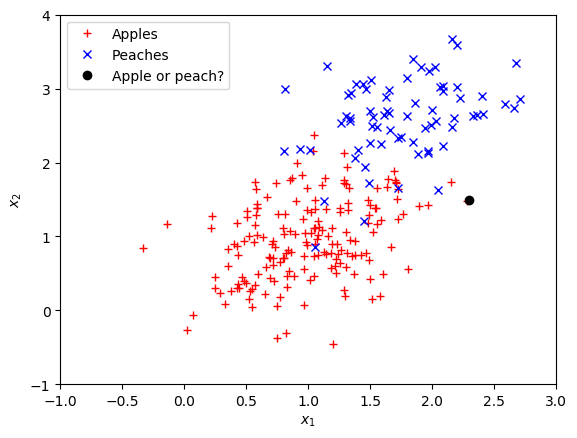

In [1]:
using Distributions, PyPlot
N = 250; p_apple = 0.7; Σ = [0.2 0.1; 0.1 0.3]
p_given_apple = MvNormal([1.0, 1.0], Σ) # p(X|y=apple)
p_given_peach = MvNormal([1.7, 2.5], Σ) # p(X|y=peach)
X = Matrix{Float64}(undef,2,N); y = Vector{Bool}(undef,N) # true corresponds to apple
for n=1:N
    y[n] = (rand() < p_apple) # Apple or peach?
    X[:,n] = y[n] ? rand(p_given_apple) : rand(p_given_peach) # Sample features
end
X_apples = X[:,findall(y)]'; X_peaches = X[:,findall(.!y)]' # Sort features on class
x_test = [2.3; 1.5] # Features of 'new' data point

function plot_fruit_dataset()
    # Plot the data set and x_test
    plot(X_apples[:,1], X_apples[:,2], "r+")   # apples
    plot(X_peaches[:,1], X_peaches[:,2], "bx") # peaches
    plot(x_test[1], x_test[2], "ko")           # 'new' unlabelled data point
    legend(["Apples"; "Peaches"; "Apple or peach?"], loc=2)
    xlabel(L"x_1"); ylabel(L"x_2"); xlim([-1,3]); ylim([-1,4])
end
plot_fruit_dataset();

### Generative Classification Problem Statement

- Given is a data set  $D = \{(x_1,y_1),\dotsc,(x_N,y_N)\}$
  - inputs $x_n \in \mathbb{R}^D$ are called **features**.
  - outputs $y_n \in \mathcal{C}_k$, with $k=1,\ldots,K$; The **discrete** targets $\mathcal{C}_k$ are called **classes**.

- We will again use the 1-of-$K$ notation for the discrete classes. Define the binary **class selection variable**
$$
y_{nk} = \begin{cases} 1 & \text{if  } \, y_n \in \mathcal{C}_k\\
0 & \text{otherwise} \end{cases}
$$
  - (Hence, the notations $y_{nk}=1$ and $y_n \in \mathcal{C}_k$ mean the same thing.)

-  The plan for generative classification: build a model for the joint pdf $p(x,y)= p(x|y)p(y)$ and use Bayes to infer the posterior class probabilities 

$$
p(y|x) = \frac{p(x|y) p(y)}{\sum_{y} p(x|y) p(y)} \propto p(x|y)\,p(y)
$$

###  1 - Model specification 

##### Likelihood

- Assume Gaussian **class-conditional distributions** with **constant covariance matrix** across the classes,
 $$
 p(x_n|\mathcal{C}_{k}) = \mathcal{N}(x_n|\mu_k,\Sigma)
 $$
with notational shorthand: $\mathcal{C}_{k} \triangleq (y_n \in \mathcal{C}_{k})$.

##### Prior

- We use a categorical distribution for the class labels $y_{nk}$: 
$$p(\mathcal{C}_{k}) = \pi_k$$

- This leads to
$$
 p(x_n,\mathcal{C}_{k}) =  \pi_k \cdot \mathcal{N}(x_n|\mu_k,\Sigma)
$$ 

- The log-likelihood for the full data set is then
$$\begin{align*}
\log\, &p(D|\theta) \stackrel{\text{IID}}{=} \sum_n \log p(x_n,\mathcal{C}_{1},\ldots,\mathcal{C}_{K} \,|\,\theta) \\
  &= \sum_n \log \prod_k p(x_n,\mathcal{C}_{k}|\theta)^{y_{nk}} \;\;\text{(use 1-of-K coding)} \\
  &=  \sum_{n,k} y_{nk} \log p(x_n,\mathcal{C}_{k}|\theta) \\
   &=  \sum_{n,k} y_{nk}  \log\mathcal{N}(x_n|\mu_k,\Sigma)  +  \sum_{n,k} y_{nk} \log \pi_k \\
   &=  \sum_{n,k} y_{nk} \underbrace{ \log\mathcal{N}(x_n|\mu_k,\Sigma) }_{ \text{see Gaussian est.} } + \underbrace{ \sum_k m_k \log \pi_k }_{ \text{see multinomial est.} } 
\end{align*}$$
where we used $m_k \triangleq \sum_n y_{nk}$.

- As usual, the rest (inference for parameters and model prediction) through straight probability theory.

### 2 -  Parameter Inference for Classification

- We'll do ML estimation for $\theta = \{ \pi_k, \mu_k, \Sigma \}$ from data $D$

-  Recall (from the previous slide) the log-likelihood (LLH)

$$
\log\, p(D|\theta) =  \sum_{n,k} y_{nk} \underbrace{ \log\mathcal{N}(x_n|\mu_k,\Sigma) }_{ \text{Gaussian} } + \underbrace{ \sum_k m_k \log \pi_k }_{ \text{multinomial} } 
$$

- Maximization of the LLH breaks down into
  -  **Gaussian density estimation** for parameters $\mu_k, \Sigma$, since the first term contains exactly the LLH for MVG density estimation (see lesson on Density Est., Eq.1) 
  - **Multinomial density estimation** for class priors $\pi_k$, since the second term holds exactly the LLH for multinomial density estimation (see lesson on Density Estimation, Eq.2). 
 

 - The ML for multinomial class prior (we've done this before!)
$$\begin{align*}   
\hat \pi_k = m_k/N 
\end{align*}$$

- Now group the data into separate classes and do MVG ML estimation for class-conditional parameters (we've done this before as well):
$$\begin{align*}
 \hat \mu_k &= \frac{ \sum_n y_{nk} x_n} { \sum_n y_{nk} } = \frac{1}{m_k} \sum_n y_{nk} x_n \\
 \hat \Sigma  &= \frac{1}{N} \sum_{n,k} y_{nk} (x_n-\hat \mu_k)(x_n-\hat \mu_k)^T \\
  &= \sum_k \hat \pi_k \cdot \underbrace{ \left( \frac{1}{m_k} \sum_{n} y_{nk} (x_n-\hat \mu_k)(x_n-\hat \mu_k)^T  \right) }_{ \text{class-cond. variance} } \\
  &= \sum_k \hat \pi_k \cdot \hat \Sigma_k
\end{align*}$$
where $\hat \pi_k$, $\hat{\mu}_k$ and $\hat{\Sigma}_k$ are the sample proportion, sample mean and sample variance for the $k$th class, respectively.

- Note that the binary class selection variable $y_{nk}$ groups data from the same class.

###  3 - Application: Class prediction for new Data

-  Let's apply the trained model: given a 'new' input $x_\bullet$, use Bayes rule to get posterior class probability
$$\begin{align*}
 p(\mathcal{C}_k|x_\bullet,\hat{\theta} ) &\propto p(\mathcal{C}_k) \,p(x_\bullet|\mathcal{C}_k) \\
  &\propto \hat{\pi}_k \exp \left\{ { - {\frac{1}{2}}(x_\bullet - \hat{\mu}_k )^T \hat{\Sigma}^{ - 1} (x_\bullet - \hat{\mu}_k )} \right\}\\
  &\propto \exp \left\{ {\hat{\mu}_k^T \hat{\Sigma}^{-1} x_\bullet - {\frac{1}{2}}\hat{\mu}_k^T \hat{\Sigma}^{ - 1} \hat{\mu}_k  + \log \hat{\pi}_k } \right\}  \\
  &=  \exp\{\beta_k^T x + \gamma_k\}
\end{align*}$$
where 
$$\begin{align*}
\beta_k &= \hat{\Sigma}^{-1} \hat{\mu}_k \\
\gamma_k &= - \frac{1}{2} \hat{\mu}_k^T \hat{\Sigma}^{-1} \hat{\mu}_k  + \log \hat{\pi}_k \,.
\end{align*}$$

- The class posterior function $$\phi(a_k) \triangleq \frac{\exp(a_k)}{\sum_{k^\prime}\exp(a_{k^\prime})}$$ is called a **softmax** function. Note that the softmax function is per definition properly normalized in the sense that $\sum_k \phi(a_k) = 1$.  

###  Discrimination Boundaries

-  The class log-posterior $\log p(\mathcal{C}_k|x) \propto \beta_k^T x + \gamma_k$ is a linear function of the input features.

-  Thus, the contours of equal probability (**discriminant functions**) are lines (hyperplanes) in feature space"
$$
\log \frac{{p(\mathcal{C}_k|x,\theta )}}{{p(\mathcal{C}_j|x,\theta )}} = \beta_{kj}^T x + \gamma_{kj} = 0
$$
where we defined $\beta_{kj} \triangleq \beta_k - \beta_j$ and similarly for $\gamma_{kj}$.

-  (homework). What happens if we had not assumed class-independent variances $\Sigma_k=\Sigma$? Are the discrimination functions still linear? quadratic?

-  How to classify a new input $x_\bullet$? The Bayesian answer is a posterior distribution $ p(\mathcal{C}_k|x_\bullet)$. If you must choose, then the class with maximum posterior class probability
$$\begin{align*}
k^* &= \arg\max_k p(\mathcal{C}_k|x_\bullet) \\
  &= \arg\max_k \left( \beta _k^T x_\bullet + \gamma_k \right)
\end{align*}$$
is an appealing decision. 

#### CODE EXAMPLE

We'll apply the above results to solve the "apple or peach" example problem.

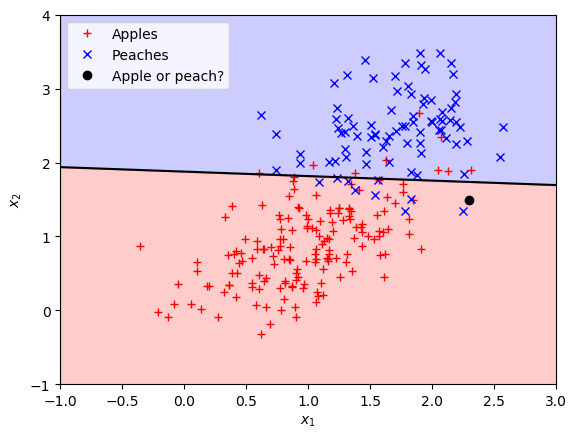

p(apple|x=x∙) = 0.7842698441755891


In [2]:
# Make sure you run the data-generating code cell first

# Multinomial (in this case binomial) density estimation
p_apple_est = sum(y.==true) / length(y)
π_hat = [p_apple_est; 1-p_apple_est]

# Estimate class-conditional multivariate Gaussian densities
d1 = fit_mle(FullNormal, X_apples')  # MLE density estimation d1 = N(μ₁, Σ₁)
d2 = fit_mle(FullNormal, X_peaches') # MLE density estimation d2 = N(μ₂, Σ₂)
Σ = π_hat[1]*cov(d1) + π_hat[2]*cov(d2) # Combine Σ₁ and Σ₂ into Σ
conditionals = [MvNormal(mean(d1), Σ); MvNormal(mean(d2), Σ)] # p(x|C)

# Calculate posterior class probability of x∙ (prediction)
function predict_class(k, X) # calculate p(Ck|X)
    norm = π_hat[1]*pdf(conditionals[1],X) + π_hat[2]*pdf(conditionals[2],X)
    return π_hat[k]*pdf(conditionals[k], X) ./ norm
end
println("p(apple|x=x∙) = $(predict_class(1,x_test))")

# Discrimination boundary of the posterior (p(apple|x;D) = p(peach|x;D) = 0.5)
β(k) = inv(Σ)*mean(conditionals[k])
γ(k) = -0.5 * mean(conditionals[k])' * inv(Σ) * mean(conditionals[k]) + log(π_hat[k])
function discriminant_x2(x1)
    # Solve discriminant equation for x2
    β12 = β(1) .- β(2)
    γ12 = (γ(1) .- γ(2))[1,1]
    return -1*(β12[1]*x1 .+ γ12) ./ β12[2]
end

plot_fruit_dataset() # Plot dataset
x1 = range(-1,length=10,stop=3)
plot(x1, discriminant_x2(x1), "k-") # Plot discrimination boundary
fill_between(x1, -1, discriminant_x2(x1), color="r", alpha=0.2)
fill_between(x1, discriminant_x2(x1), 4, color="b", alpha=0.2);

###  Recap Generative Classification

- Model speccification:  $p(x,\mathcal{C}_k|\,\theta) = \pi_k \cdot \mathcal{N}(x|\mu_k,\Sigma)$

- If the class-conditional distributions are Gaussian with equal covariance matrices across classes ($\Sigma_k = \Sigma$), then
    the discriminant functions are hyperplanes in feature space.

- ML estimation for $\{\pi_k,\mu_k,\Sigma\}$ breaks down to simple density estimation for Gaussian and multinomial.

- Posterior class probability is a softmax function
$$ p(\mathcal{C}_k|x,\theta ) \propto \exp\{\beta_k^T x + \gamma_k\}$$
where $\beta _k= \Sigma^{-1} \mu_k$ and $\gamma_k=- \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k  + \log \pi_k$.

# Discriminative Classification

### Preliminaries

- Goal 
  - Introduction to discriminative classification models
- Materials        
  - Mandatory
    - These lecture notes
  - Optional
    - Bishop pp. 203-206 
    - [T. Minka (2005), Discriminative models, not discriminative training](./files/Minka-2005 -Discriminative-models-not-discriminative-training.pdf)

## Bayesian Logistic Regression

- A data set is given by  $D = \{(x_1,y_1),\dotsc,(x_N,y_N)\}$ with $x_n \in \mathbb{R}^D$ and $y_n \in \{0,1\}$.


### Model Specification

- The likelihood model is given by
$$\begin{align*}
p(y_n \,|\, x_n, w) &= \mathrm{Bernoulli}\left(y_n \,|\, \sigma(w^T x_n) \right) \\
  &=  \sigma(w^T x_n)^{y_n} \left(1 - \sigma(w^T x_n)\right)^{(1-y_n)} \tag{B-4.89} \\
  &= \sigma\left( (2y_n-1) w^T x_n\right)
\end{align*}$$
where $$\sigma(a) = 1/(1+e^{-a})$$ is the _logistic_ function. Note that for the 3rd line, we have made use of the fact that $\sigma(-a) = 1-\sigma(a)$.
  - (Each of these three models are equivalent. We mention all three notational options since they all appear in the literature).  
  
- <font color="red"> Add a plot of the logistic function</font>
  
- We will consider a Gaussian prior on the weights: 
  $$\begin{align*}
p(w) = \mathcal{N}(w \,|\, m_0, S_0) \tag{B-4.140}
\end{align*}$$

### Inference

- The posterior for the weights follows by Bayes rule
$$\begin{align*}
p(w \,|\, D) \propto \mathcal{N}(w \,|\, m_0, S_0) \cdot \prod_{n=1}^N \sigma\left( (2y_n-1) w^T x_n\right) \tag{B-4.142}
\end{align*}$$

- In principle, Bayesian inference is done now. Unfortunately, the posterior is not Gaussian and the evidence $p(D)$ is also not analytically computable. 

### Predictive distribution

- For a new data point $x_\bullet$, the predictive distribution for $y_\bullet$ is given by 
$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &= \int p(y_\bullet = 1 \,|\, x_\bullet, w) \, p(w\,|\, D) \,\mathrm{d}w \\
  &= \int \sigma(w^T x_\bullet) \, p(w\,|\, D) \,\mathrm{d}w \tag{B-4.145}
\end{align*}$$

- After substitution of $p(w | D)$ from B-4.142, we have an integral that is not solvable in closed-form. 

- Many methods have been developed to approximate the integrals for the predictive distribution and evidence. Here, we present the **Laplace approximation**, which is one of the simplest methods with broad applicability to Bayesian calculations.

## The Laplace Approximation

- The central idea of the Laplace approximation is to approximate a (possibly unnormalized) distribution $f(z)$ by a Gaussian distribution $q(z)$. 

- Note that $\log q(z)$ is a second order polynomial in $z$, so we will find the Gaussian by fitting a parabola to $\log f(z)$. 


##### estimation of mean 

- The mean ($z_0$) of q(z) is placed on the mode of $\log f(z)$, i.e., 

$$z_0 = \arg\max_z \log f(z) \tag{B-4.126}$$ 
  
##### estimation of variance

- Since the gradient $\nabla \left. f(z) \right|_{z=z_0}$ vanishes at the mode, we can (Taylor) expand $\log f(z)$ around $z=z_0$ as 
$$
\log f(z) \approx \log f(z_0) - \frac{1}{2} (z-z_0)^T A (z-z_0) \tag{B-4.131}
$$
where the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix) $A$ is defined by
$$
A = - \nabla \nabla \left. \log f(z) \right|_{z=z_0} \tag{B-4.132}
$$

##### Laplace approximation

- After taking exponentials in eq. B-4.131, we obtain

$$
f(z) \approx f(z_0) \exp\left( - \frac{1}{2} (z-z_0)^T A (z-z_0)\right) 
$$

- We can now identify $q(z)$ as
$$
q(z) = \mathcal{N}\left( z\,|\,z_0, A^{-1}\right) \tag{B-4.134}
$$
with $z_0$ and $A$ defined by eqs. B-4.126 and B-4.132.
- insert fig 4.14



### Bayesian Evidence Estimation with the Laplace Approximation

### Bayesian Logistic Regression with the Laplace Approximation

- Let's get back to the challenge of computing the predictive class distribution (B-4.145) for Bayesian logistic regression. We first work out the Gaussian Laplace approximation $q(w)$ to the posterior weight distribution 
$$\begin{align*}
p(w \mid D) \propto \mathcal{N}(w \,|\, m_0, S_0) \cdot \prod_{n=1}^N \sigma\left( (2y_n-1) w^T x_n\right) \tag{B-4.142}
\end{align*}$$

- It is straightforward to compute the gradient and Hessian of $\log p(w \,|\, D)$:
$$\begin{align*}
\nabla_w \log p(w \,|\, D) &= S_0^{-1}\cdot \left(m_0-w\right) + \sum_n (2y_n-1) (1-\sigma_n) x_n \\
\nabla_w \nabla_w \log p(w \,|\, D) &= -S_0^{-1} - \sum_n \sigma_n (1-\sigma_n) x_n x_n^T \tag{B-4.143}
\end{align*}$$
where we used shorthand $\sigma_n$ for $\sigma\left( (2y_n-1) w^T x_n\right)$. 

- We can use the gradient to find the mode $w_{\text{MAP}}$ of $\log p(w \,|\, D)$ and use the Hessian to get the variance of $q(w)$, leading to
$$\begin{align*}
q(w) &= \mathcal{N}\left(w\,|\, w_{\text{MAP}}, S_N\right) \tag{B-4.144}\\
S_N^{-1} &= S_0^{-1} + \sum_n \sigma_n (1-\sigma_n) x_n x_n^T \tag{B-4.143}
\end{align*}$$

- In the analytically unsolveable expressions for evidence and the predictive distribution (estimating the class of a new observation), we proceed with the Laplace approximation to the weights posterior. For a new observation $x_\bullet$, the class probability is now
$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &\approx \int p(y_\bullet = 1 \,|\, x_\bullet, w) \, q(w) \,\mathrm{d}w \\
  &= \int \sigma(w^T x_\bullet) \, \mathcal{N}\left(w\,|\, w_{\text{MAP}}, S_N\right) \,\mathrm{d}w \tag{B-4.145}
\end{align*}$$

- This looks better but we need two more clever tricks to evaluate this expression. First, note that $w$ only appears in inner products, so through substitution of $a:=w^T x_\bullet$, the expression simplifies to an integral over the scalar $a$ (see Bishop for derivation):
$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &\approx \int \sigma(a) \, \mathcal{N}\left(a\,|\, \mu_a, \Sigma_a\right) \,\mathrm{d}a \tag{B-4.151}\\
\mu_a  &= w^T_{\text{MAP}} x_\bullet \tag{B-4.149}\\
\Sigma_a &= x^T_\bullet S_N x_\bullet \tag{B-4.150}
\end{align*}$$

- Secondly, while the integral of the product of a logistic function with a Gaussian is not analytically solvable, the integral of the product of a Gaussian CDF (cumulative distribution function) with a Gaussian _does_ have a closed-form solution. Fortunately, 
$$\Phi(\lambda a) \approx \sigma(a)$$
with the Gaussian CDF $\Phi(x)= \frac{1}{\sqrt(2\pi)}\int_{-\infty}^{x}e^{-t^2/2}\mathrm{d}t$, $ \lambda^2= \pi / 8 $ and $\sigma(a) = 1/(1+e^{-a})$. 

- Finally, substituting $\Phi(\lambda a)$ with $ \lambda^2= \pi / 8 $ for $\sigma(a)$ leads to 
$$\begin{align*}
p(y_\bullet = 1 \mid x_\bullet, D) &\approx \int \Phi(\lambda a) \, \mathcal{N}\left(a\,|\, \mu_a, \Sigma_a\right) \,\mathrm{d}a \\ &= \Phi\left( \frac{\mu_a}{\sqrt(\lambda^{-2} +\sigma_a^2)}\right) \tag{B-4.152}
\end{align*}$$

- We now have an approximate but closed-form expression for the predictive class distribution for a new observation with a Bayesian logistic regression model.  

- Note that, by eq. B-4.143, the variance $S_N$ (and consequently $\sigma_a^2$) for the weight vector depends on the distribution of the training set. Large uncertainty about the weights (in areas with little training data and uninformative prior variance $S_0$) takes the posterior class probability eq. B-4.152 closer to $0.5$. Does that make sense?

- Apparently, the Laplace approximation does lead to closed-form solutions for Bayesian logistic regression (although admittedly, the derivation is no walk in the park). 

### <font color="red">Code example for Bayesian logistic regression</font>

###  Problem: difficult class-conditional data distribitions

Our task will be the same as in the preceding class on (generative) classification. But this time, the class-conditional data distributions look very non-Gaussian, yet the linear discriminative boundary looks easy enough:

In [2]:
# Generate dataset {(x1,y1),...,(xN,yN)}
# x is a 2-d feature vector [x_1;x_2]
# y ∈ {false,true} is a binary class label
# p(x|y) is multi-modal (mixture of uniform and Gaussian distributions)
using PyPlot
include("scripts/lesson8_helpers.jl")
N = 200
X, y = genDataset(N) # Generate data set, collect in matrix X and vector y
X_c1 = X[:,findall(.!y)]'; X_c2 = X[:,findall(y)]' # Split X based on class label
X_test = [3.75; 1.0] # Features of 'new' data point
function plotDataSet()
    plot(X_c1[:,1], X_c1[:,2], "bx", markersize=8)
    plot(X_c2[:,1], X_c2[:,2], "r+", markersize=8, fillstyle="none")
    plot(X_test[1], X_test[2], "ko")   
    xlabel(L"x_1"); ylabel(L"x_2"); 
    legend([L"y=0", L"y=1",L"y=?"], loc=2)
    xlim([-2;10]); ylim([-4, 8])
end
plotDataSet();

ArgumentError: ArgumentError: Package PyPlot not found in current path:
- Run `import Pkg; Pkg.add("PyPlot")` to install the PyPlot package.


###  Main Idea of Discriminative Classification 

- Again, a data set is given by  $D = \{(x_1,y_1),\dotsc,(x_N,y_N)\}$ with $x_n \in \mathbb{R}^D$ and $y_n \in \mathcal{C}_k$, with $k=1,\ldots,K$.

-  Sometimes, the precise assumptions of the (multinomial-Gaussian) generative model $$p(x_n,\mathcal{C}_k|\theta) =  \pi_k \cdot \mathcal{N}(x_n|\mu_k,\Sigma)$$ clearly do not match the data distribution.

- Here's an **IDEA**! Let's model the posterior $$p(\mathcal{C}_k|x_n)$$  _directly_, without any assumptions on the class densities.

- Of course, this implies also that we build direct models for the **discrimination boundaries** 
  $$\log \frac{p(\mathcal{C}_k|x_n)}{p(\mathcal{C}_j|x_n)} \overset{!}{=} 0$$

### 1. Model Specification 

- <span style="color:blue">[Q.]</span> What model should we use for $p(\mathcal{C}_k|x_n)$?

-   <span style="color:blue">[A.]</span> Get inspiration from the generative approach: choose the familiar softmax structure **with linear discrimination bounderies** for the posterior class probability
$$
p(\mathcal{C}_k|x_n,\theta) = \frac{e^{\theta_k^T x_n}}{\sum_j e^{\theta_j^T x_n}}
$$
but **do not impose a Gaussian structure on the class features**.

- $\Rightarrow$ There are **two key differences** between the discriminative and generative approach: 
  1. In the discriminative approach, the parameters $\theta_k$ are **not** structured into $\{\mu_k,\Sigma,\pi_k \}$. This provides discriminative approach with more flexibility.
  2. ML learning for the discriminative approach by optimization of _conditional_ likelihood $\prod_n p(y_n|x_n,\theta)$ rather than _joint_ likelihood $\prod_n p(y_n,x_n|\theta)$.

 ###  2. ML Estimation for Discriminative Classification
 

-  The conditional log-likelihood for discriminative classification is 

     $$
    \mathrm{L}(\theta) = \log \prod_n \prod_k {p(\mathcal{C}_k|x_n,\theta)}^{y_{nk}} 
     $$

     
- Computing the gradient $\nabla_{\theta_k} \mathrm{L}(\theta)$ (NB: revised text) leads to (for proof, see next slide) 

$$
\nabla_{\theta_k} \mathrm{L}(\theta) = \sum_n \Big( \underbrace{y_{nk}}_{\text{target}} - \underbrace{\frac{e^{\theta_k^T x_n}}{ \sum_j e^{\theta_j^T x_n}}}_{\text{prediction}} \Big)\cdot x_n 
$$

  
- Compare this to the gradient for _linear_ regression:

$$
\nabla_\theta \mathrm{L}(\theta) =  \sum_n \left(y_n - \theta^T x_n \right)  x_n
$$

- In both cases

$$
\nabla_\theta \mathrm{L} =  \sum_n \left( \text{target}_n - \text{prediction}_n \right) \cdot \text{input}_n 
$$

- The parameter vector $\theta$ for logistic regression can be estimated through iterative gradient-based adaptation. E.g. (with iteration index $i$),

$$
\hat{\theta}^{(i+1)} =  \hat{\theta}^{(i)} + \eta \cdot \left. \nabla_\theta   \mathrm{L}(\theta)  \right|_{\theta = \hat{\theta}^{(i)}}
$$

 ###  2. <span style="color:red">(OPTIONAL)</span> Proof of Derivative of Log-likelihood for  Discriminative Classification


- The Log-likelihood is $
    \mathrm{L}(\theta) = \log \prod_n \prod_k {\underbrace{p(\mathcal{C}_k|x_n,\theta)}_{p_{nk}}}^{y_{nk}} = \sum_{n,k} y_{nk} \log p_{nk}$

     
- Use the fact that the softmax $\phi_k \equiv e^{a_k} / {\sum_j e^{a_j}}$ has analytical derivative:

$$ \begin{align*}
 \frac{\partial \phi_k}{\partial a_j} &= \frac{(\sum_j e^{a_j})e^{a_k}\delta_{kj}-e^{a_j}e^{a_k}}{(\sum_j e^{a_j})^2} = \frac{e^{a_k}}{\sum_j e^{a_j}}\delta_{kj} - \frac{e^{a_j}}{\sum_j e^{a_j}} \frac{e^{a_k}}{\sum_j e^{a_j}}\\
     &= \phi_k \cdot(\delta_{kj}-\phi_j)
 \end{align*}$$

<!---
%    -  Again we try to minimize the cross-entropy ($\sum_{nk} y_{nk} \log \frac{y_{nk}}{p_{nk}}$) between the data `targets' $t_{nk}$ and the model outputs $p_{nk}$.
--->

 -  Take the derivative of $\mathrm{L}(\theta)$ (or: how to spend a hour ...)
$$\begin{align*} 
\nabla_{\theta_j} \mathrm{L}(\theta) &= \sum_{n,k} \frac{\partial \mathrm{L}_{nk}}{\partial p_{nk}} \cdot\frac{\partial p_{nk}}{\partial a_{nj}}\cdot\frac{\partial a_{nj}}{\partial \theta_j} \\
  &= \sum_{n,k} \frac{y_{nk}}{p_{nk}} \cdot p_{nk} (\delta_{kj}-p_{nj}) \cdot x_n \\
  &= \sum_n \Big( y_{nj} (1-p_{nj}) -\sum_{k\neq j} y_{nk} p_{nj} \Big) \cdot x_n \\
  &= \sum_n \left( y_{nj} - p_{nj} \right)\cdot x_n \\
  &= \sum_n \Big( \underbrace{y_{nj}}_{\text{target}} - \underbrace{\frac{e^{\theta_j^T x_n}}{\sum_{j^\prime} e^{\theta_{j^\prime}^T x_n}}}_{\text{prediction}} \Big)\cdot x_n 
\end{align*}$$
  

### 3. Application - Classify a new input

-  Discriminative model-based prediction for a new input $x_\bullet$ is easy, namely substitute the ML estimate in the model to get

$$
p(\mathcal{C}_k |\, x_\bullet,\hat\theta) = \frac{ \mathrm{exp}\left( \hat \theta_k^T x_\bullet \right) }{ \sum_{k^\prime} \mathrm{exp}\left(\hat \theta_{k^\prime}^T x_\bullet \right)} 
  \propto \mathrm{exp}\left(\hat \theta_k^T x_\bullet\right) 
$$

-  The contours of equal probability (**discriminant boundaries**) are lines (hyperplanes) in feature space given by
$$
\log \frac{{p(\mathcal{C}_k|x,\hat \theta )}}{{p(\mathcal{C}_j|x,\hat \theta )}} = \left( \hat{\theta}_{k} - \hat{\theta}_j\right) ^T x = 0
$$

#### CODE EXAMPLE

Let us perform ML estimation of $\theta$ on the data set from the introduction. To allow an offset in the discrimination boundary, we add a constant 1 to the feature vector $x$. We only have to specify the (negative) log-likelihood and the gradient w.r.t. $\theta$. Then, we use an off-the-shelf optimisation library to minimize the negative log-likelihood.

We plot the resulting maximum likelihood discrimination boundary. For comparison we also plot the ML discrimination boundary obtained from the generative Gaussian classifier from lesson 7.

In [4]:
using Optim # Optimization library

y_1 = zeros(length(y))# class 1 indicator vector
y_1[findall(y)] .= 1
X_ext = vcat(X, ones(1, length(y))) # Extend X with a row of ones to allow an offset in the discrimination boundary

# Implement negative log-likelihood function
function negative_log_likelihood(θ::Vector)
    # Return negative log-likelihood: -L(θ)
    p_1 = 1.0 ./ (1.0 .+ exp.(-X_ext' * θ))   # P(C1|X,θ)
    return -sum(log.( (y_1 .* p_1) + ((1 .- y_1).*(1 .- p_1))) ) # negative log-likelihood
end

# Use Optim.jl optimiser to minimize the negative log-likelihood function w.r.t. θ
results = optimize(negative_log_likelihood, zeros(3), LBFGS())
θ = results.minimizer

# Plot the data set and ML discrimination boundary
plotDataSet()
p_1(x) = 1.0 ./ (1.0 .+ exp(-([x;1.]' * θ)))
boundary(x1) = -1 ./ θ[2] * (θ[1]*x1 .+ θ[3])
plot([-2.;10.], boundary([-2.; 10.]), "k-");
# # Also fit the generative Gaussian model from lesson 7 and plot the resulting discrimination boundary for comparison
generative_boundary = buildGenerativeDiscriminationBoundary(X, y)
plot([-2.;10.], generative_boundary([-2;10]), "k:");
legend([L"y=0";L"y=1";L"y=?";"Discr. boundary";"Gen. boundary"], loc=3);

Given $\hat{\theta}$, we can classify a new input $x_\bullet = [3.75, 1.0]^T$:

x_test = [3.75;1.0]
println("P(C1|x•,θ) = $(p_1(x_test))")

ArgumentError: ArgumentError: Package Optim not found in current path:
- Run `import Pkg; Pkg.add("Optim")` to install the Optim package.


- The generative model gives a bad result because the feature distribution of one class is clearly non-Gaussian: the model does not fit the data well. 

- The discriminative approach does not suffer from this problem because it makes no assumptions about the feature distribition $p(x|y)$, it just estimates the conditional class distribution $p(y|x)$ directly.

### Recap Classification

<table>
<tr> <td></td><td style="text-align:center"><b>Generative</b></td> <td style="text-align:center"><b>Discriminative</b></td> </tr> 

<tr> <td>1</td><td>Like <b>density estimation</b>, model joint prob.
$$p(\mathcal{C}_k) p(x|\mathcal{C}_k) = \pi_k \mathcal{N}(\mu_k,\Sigma)$$</td> <td>Like (linear) <b>regression</b>, model conditional
$$p(\mathcal{C}_k|x,\theta)$$</td> </tr>

<tr> <td>2</td><td>Leads to <b>softmax</b> posterior class probability
$$ p(\mathcal{C}_k|x,\theta ) = e^{\theta_k^T x}/Z$$
with <b>structured</b> $\theta$</td> <td> <b>Choose</b> also softmax posterior class probability
$$ p(\mathcal{C}_k|x,\theta ) = e^{\theta_k^T x}/Z$$
but now with 'free' $\theta$</td> </tr>

<tr> <td>3</td><td>For Gaussian $p(x|\mathcal{C}_k)$ and multinomial priors,
$$\hat \theta_k  = \left[ {\begin{array}{c}
   { - \frac{1}{2} \mu_k^T \sigma^{-1} \mu_k  + \log \pi_k}  \\
   {\sigma^{-1} \mu_k }  \\
\end{array}} \right]$$
<b>in one shot</b>.</td> <td>Find $\hat\theta_k$ through gradient-based adaptation
$$\nabla_{\theta_k}\mathrm{L}(\theta) = \sum_n \Big( y_{nk} - \frac{e^{\theta_k^T x_n}}{\sum_{k^\prime} e^{\theta_{k^\prime}^T x_n}} \Big)\, x_n$$ </td> </tr>
</table>

In [3]:
open("../../styles/aipstyle.html") do f
    display("text/html", read(f,String))
end

<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->